In [1]:
import sys
sys.path.append("..")  # Ensure project root is found

# Import configurations
from configs.plot_config import apply_plot_settings
from configs.math_functions import F
from configs.parameters import *
from configs.filenames import *

import matplotlib.pyplot as plt
import numpy as np
import os

C = float(os.getenv("C", C))
sig = float(os.getenv("sig", sig))
itr = int(os.getenv("itr", itr))

print(f"\n📢 Using parameters: C={C}, sig={sig}, itr={itr}")


📢 Using parameters: C=0.01, sig=0.1, itr=20000


In [2]:
output_dir = "../data/"

params = get_params_for_filename(param_keys, globals())
filename = get_filename("discrete", "WCM", **params)
savefile = os.path.join(output_dir, filename)
print(f"✅ Opened {savefile}")

data = np.load(savefile, allow_pickle=True)      
t, EE, II = data[:,0], data[:,1], data[:,2]

✅ Opened ../data/WCM_DISCRETE_delay_itr=20000_dt=0.005_tau=1_wee=20_wei=21_wie=16_wii=6_ie=1.5_ii=-0.5_E0=0_I0=0.npy


# Phase shift by disturbance

In [3]:
# Define perturbation function
def perturbation(impulse_power, impulse_onset, impulse_width, dt, t):
    return impulse_power * (np.heaviside(impulse_onset/dt + impulse_width/dt - t, 1) - np.heaviside(impulse_onset/dt - t, 1))

# Define function for perturbed calculations
def calculate_E_and_I_perturbed(EIp, EIp_delay, dt, t_imp, k):
    Ep, Ip = EIp
    Ep_delay, Ip_delay = EIp_delay
    ie, ii, wee, wei, wie, wii, impulse_power, impulse_onset, impulse_width = k

    perturb = perturbation(impulse_power, impulse_onset, impulse_width, dt, t_imp)

    sigmoid_Ep = F(Ep_delay)
    sigmoid_Ip = F(Ip_delay)

    dEp = -Ep + ie + wee * sigmoid_Ep - wei * sigmoid_Ip + perturb
    dIp = -Ip + ii + wie * sigmoid_Ep - wii * sigmoid_Ip + perturb

    return np.array([dEp, dIp])

# Initialize parameters

data_per = []

# Loop for perturbation analysis
for i in range(250):
    print(i, end='\r')
    impulse_onset = 20 + i * impulse_stepsize
    k = np.array([ie, ii, wee, wei, wie, wii, impulse_power, impulse_onset, impulse_width])

    tp = np.linspace(0, (itr + 1) * dt, itr)
    EIp = np.zeros((2, itr))

    # Vectorized computation loop
    for n in range(itr - 1):
        EIp[:, n + 1] = EIp[:, n] + dt * calculate_E_and_I_perturbed(EIp[:, n], EIp[:, n - d], dt, n, k)

    # Extract Ep and Ip
    Ep, Ip = EIp

    # Define transient cutoff and index range
    transient_cutoff = 75  # 15ms
    cutoff = int(transient_cutoff / dt)
    start_idx, end_idx = cutoff + 1000, cutoff + 2500

    EE_window = EE[start_idx:end_idx]
    t_window = t[start_idx:end_idx]
    EEp_window = Ep[start_idx:end_idx]
    tp_window = tp[start_idx:end_idx]

    # Compute min values and their indices
    EE_min_idx = np.argmin(EE_window)
    EEp_min_idx = np.argmin(EEp_window)

    # Compute phase shift
    phaseshift = (EEp_min_idx - EE_min_idx) * dt

    # Append data
    data_per.append([impulse_onset, phaseshift])

# Convert list to NumPy array for better performance
data_per = np.array(data_per)

# Save the data
params = get_params_for_filename(param_keys, globals())
filename = get_filename("discrete", "Direct_PRC", **params)
savefile = os.path.join(output_dir, filename)
np.save(savefile, data_per, allow_pickle=True)

print(f"✅ Data saved to {savefile}")

✅ Data saved to ../data/Direct_PRC_WCM_DISCRETE_delay_itr=20000_dt=0.005_tau=1_wee=20_wei=21_wie=16_wii=6_ie=1.5_ii=-0.5_stepsize=0.07_impulse_power=0.07_impulse_width=1.npy


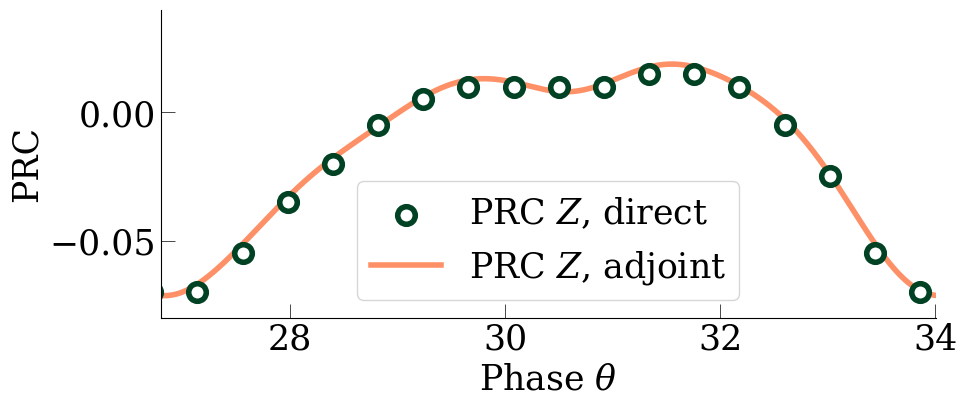

In [4]:
params = get_params_for_filename(param_keys, globals())
filename = get_filename("discrete", "PRC", **params)
savefile = os.path.join(output_dir, filename)
data      = np.load(savefile, allow_pickle=True)          
t, ZE, ZI = data[:,0], data[:,1], data[:,2]
Z = np.add(ZE, ZI)

params = get_params_for_filename(param_keys, globals())
filename = get_filename("discrete", "Direct_PRC", **params)
savefile = os.path.join(output_dir, filename)
data      = np.load(savefile, allow_pickle=True)  
impulse_onset, phaseshift = data[:,0], data[:,1]

### don't plot all data
#######################
jump = 6
impulse_onset = impulse_onset[::jump]
phaseshift = phaseshift[::jump]

t = t-0.5
Z = Z * 0.025
phase_length = 7.2065
phase_onset  = 26.8

apply_plot_settings()
fig, ax = plt.subplots(figsize=(10, 4))  # Explicitly define figure size

ax.scatter(impulse_onset, phaseshift, label='PRC $Z$, direct', s=160, facecolors='white', edgecolors= '#014225', linewidths = 4, zorder=2)
ax.plot(t, Z, label='PRC $Z$, adjoint', color = '#FD4700', zorder=1, linewidth = 4, alpha = 0.6)
ax.set_xlim(phase_onset, phase_onset+phase_length)
ax.set_ylim(-0.08, 0.04)
ax.set_xlabel(r'Phase $\theta$')
ax.set_ylabel('PRC')
ax.legend()

plt.show()